In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!cp drive/MyDrive/TGIT/test.csv .
!cp drive/MyDrive/TGIT/train.csv .

In [24]:
!pip install catboost -q

from catboost import CatBoostClassifier, metrics, cv, Pool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.5 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

In [11]:
df_train = pd.read_csv('train.csv')
df_train.head()

data_1    data_2    data_3    data_4    data_5    data_6    data_7  \
0 -0.266033 -0.496437 -0.572447 -0.220903  0.266033  0.643705  0.365796   
1  0.125475 -0.007605 -0.030418  0.285171  0.574144  0.418251  0.304183   
2  0.130435  0.445652  0.358696  0.086957 -0.076087  0.173913  0.173913   
3  0.032628 -0.019400  0.033510 -0.009700  0.037919 -0.014109  0.008818   
4  0.006105  0.005723  0.004197 -0.001145 -0.009538 -0.009538 -0.000382   

     data_8    data_9   data_10  ...  data_292  data_293  data_294  data_295  \
0  0.375297  0.014252 -0.527316  ...       NaN       NaN       NaN       NaN   
1  0.277567  0.433460  0.231939  ...       NaN       NaN       NaN       NaN   
2  0.304348  0.141304  0.304348  ...       NaN       NaN       NaN       NaN   
3 -0.005291  0.027337 -0.037919  ...       NaN       NaN       NaN       NaN   
4 -0.006868 -0.006105 -0.012591  ...       NaN       NaN       NaN       NaN   

   data_296  data_297  data_298  data_299  data_300  label  
0       NaN       NaN       NaN       NaN       NaN      0  
1       NaN       NaN       NaN       NaN       NaN      0  
2       NaN       NaN       NaN       NaN       NaN      0  
3       NaN       NaN       NaN       NaN       NaN      1  
4       NaN       NaN       NaN       NaN       NaN      0  

[5 rows x 301 columns]

# Смотрим на данные

### Спектограммы звуков

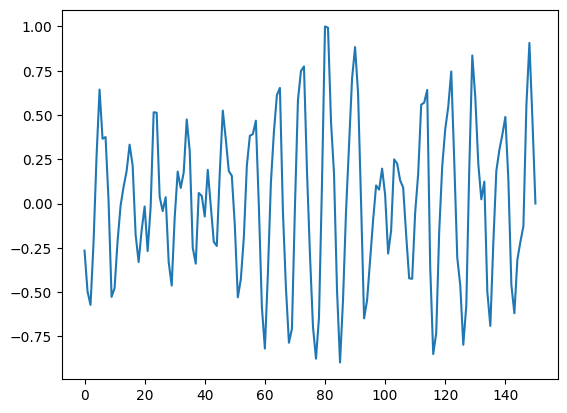

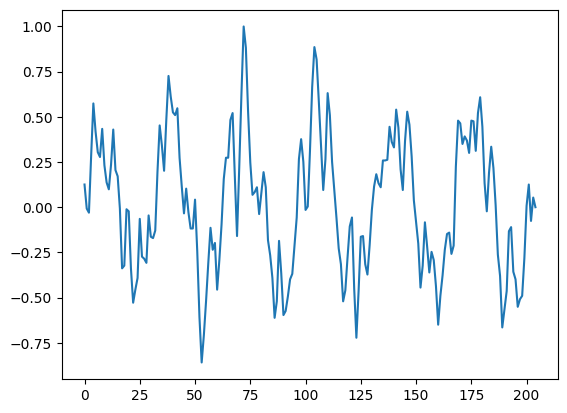

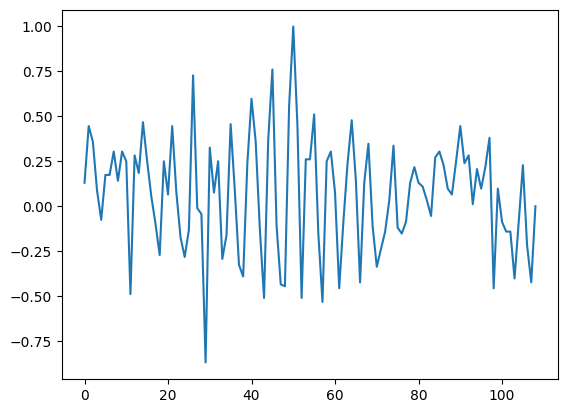

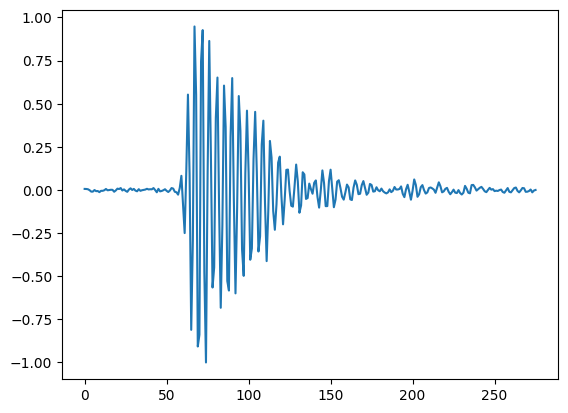

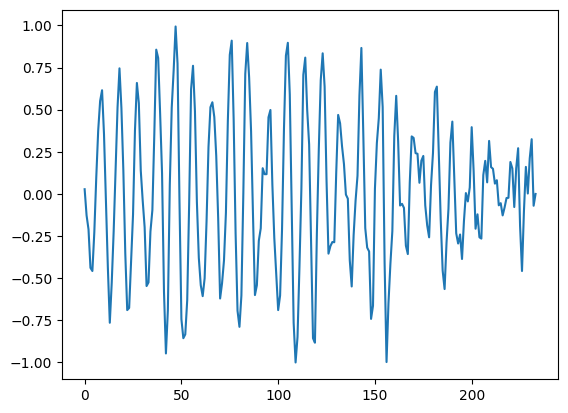

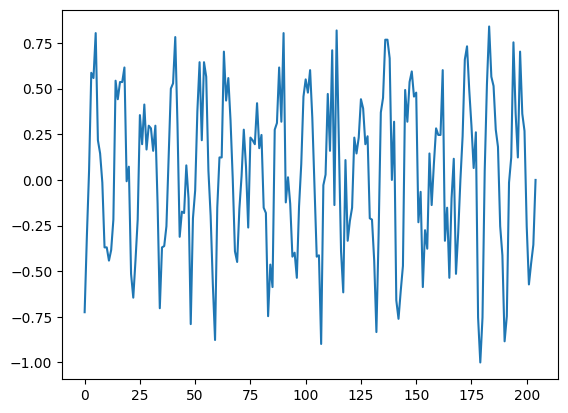

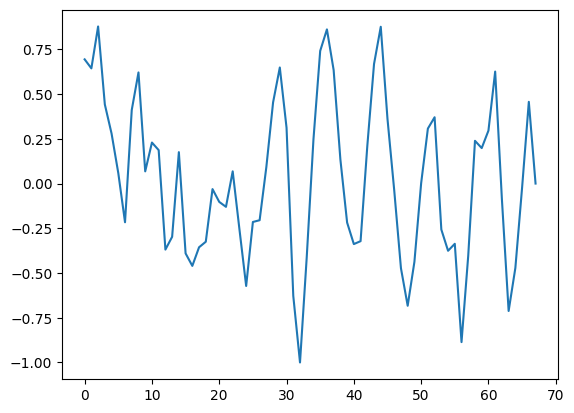

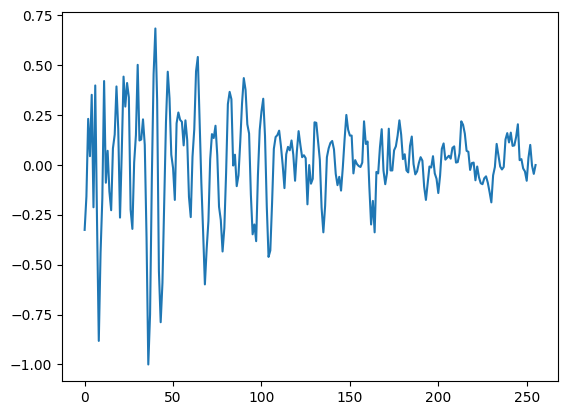

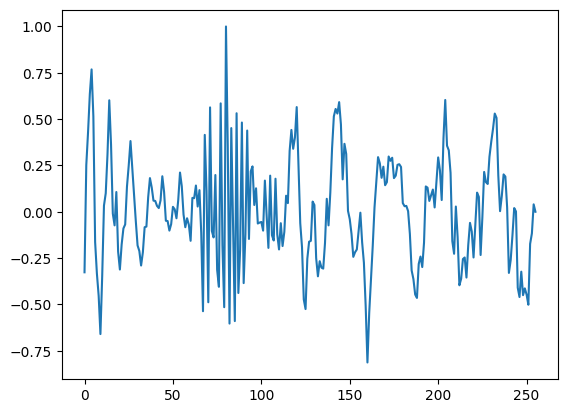

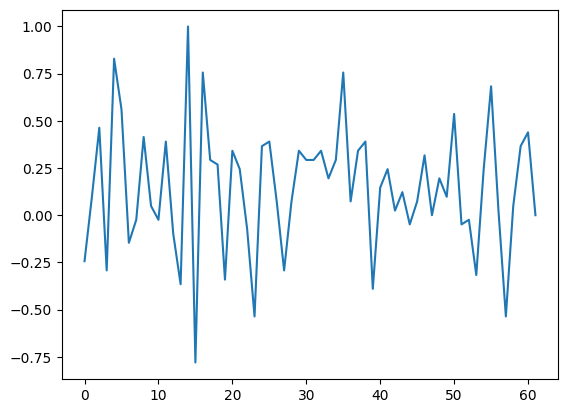

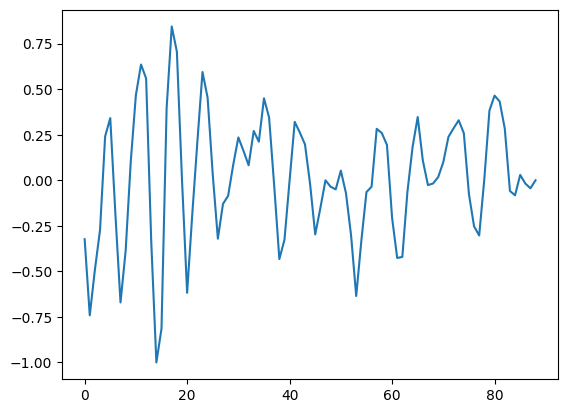

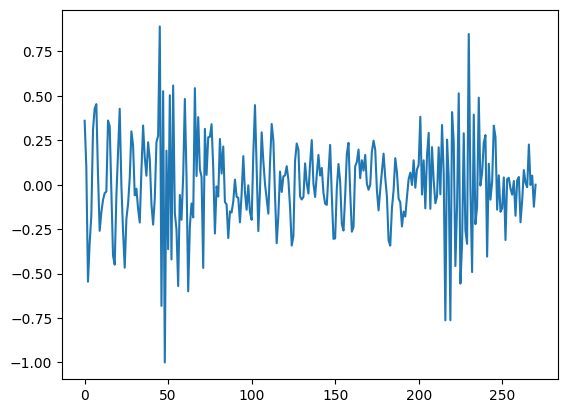

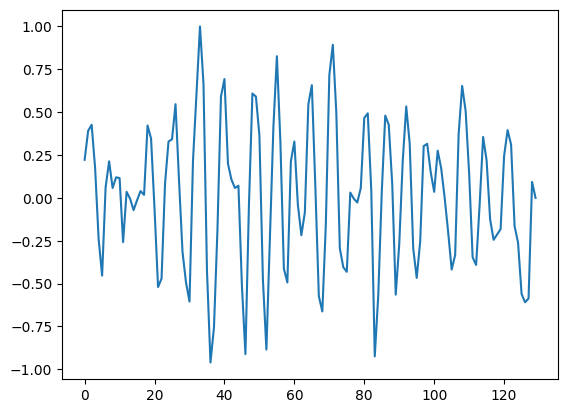

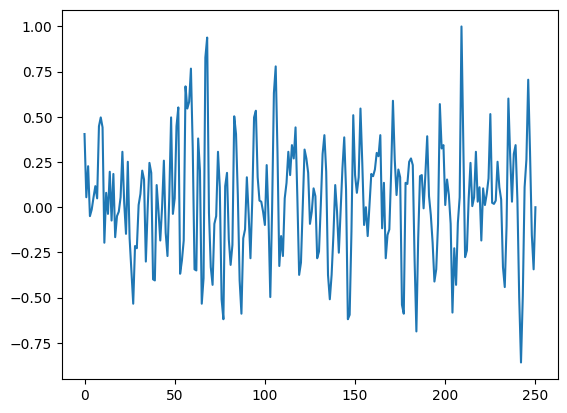

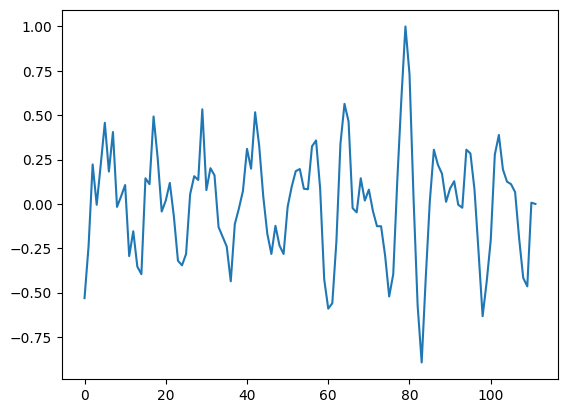

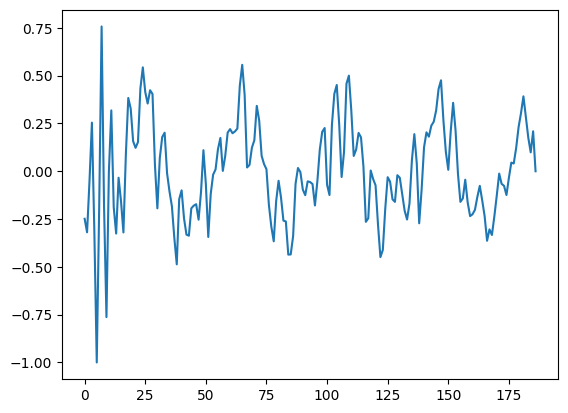

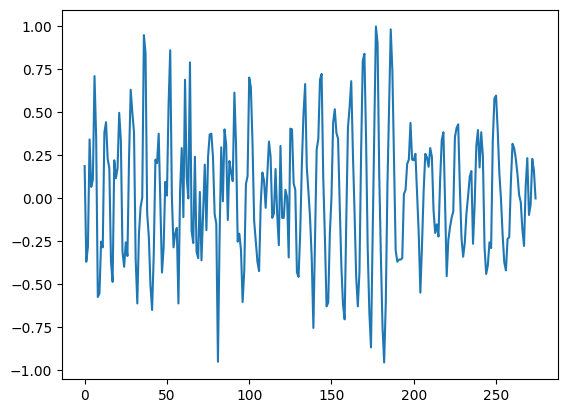

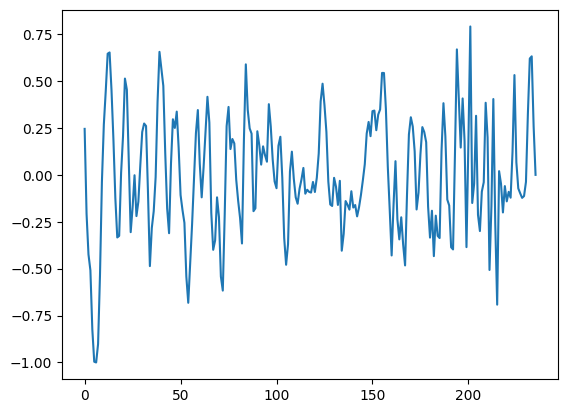

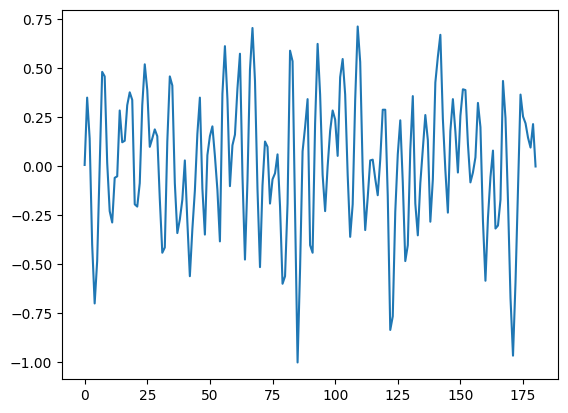

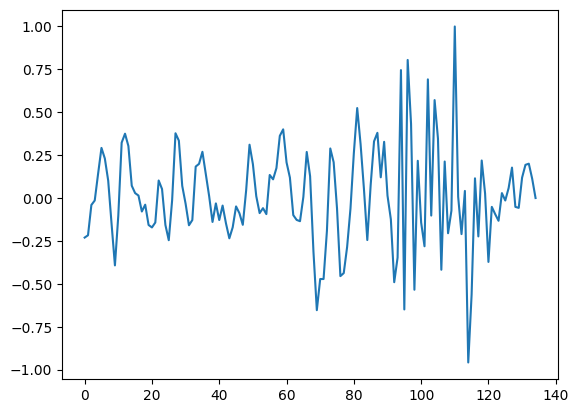

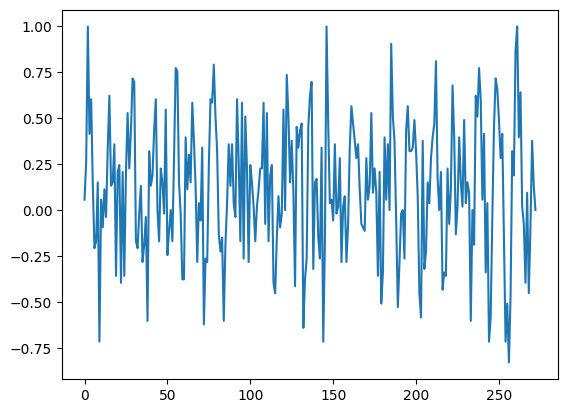

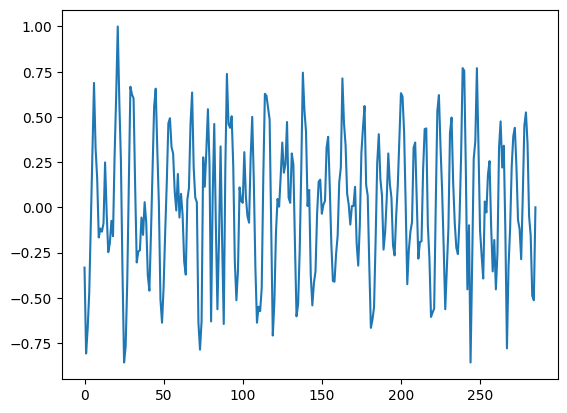

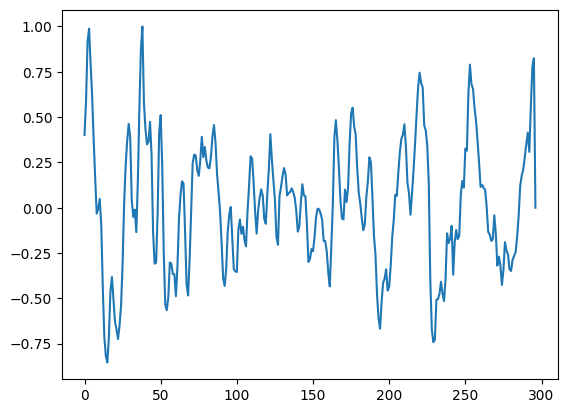

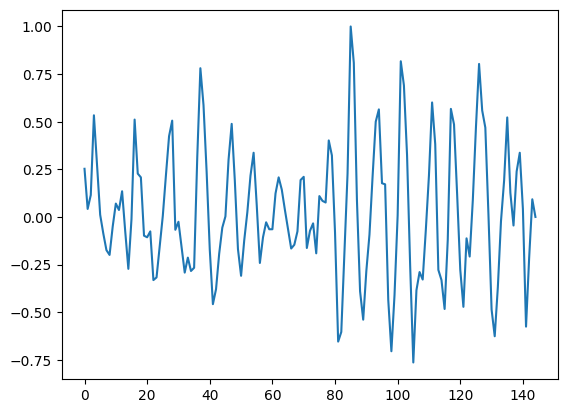

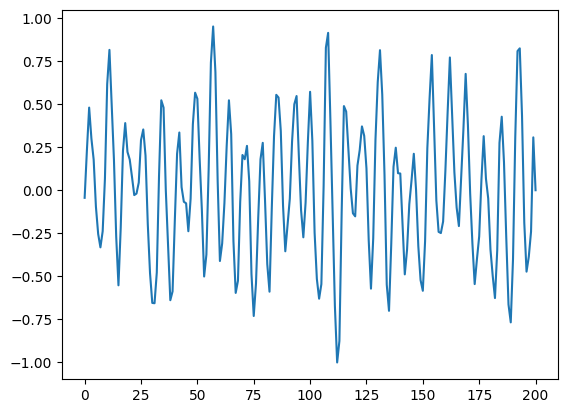

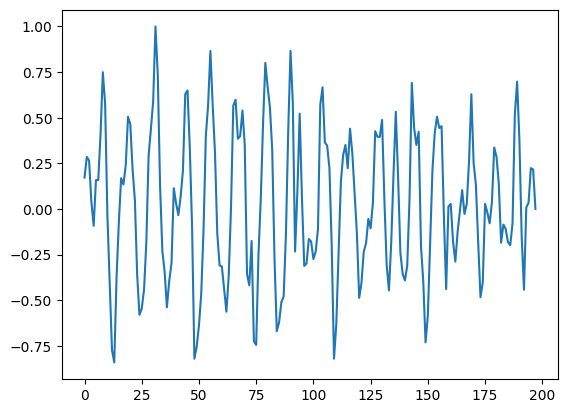

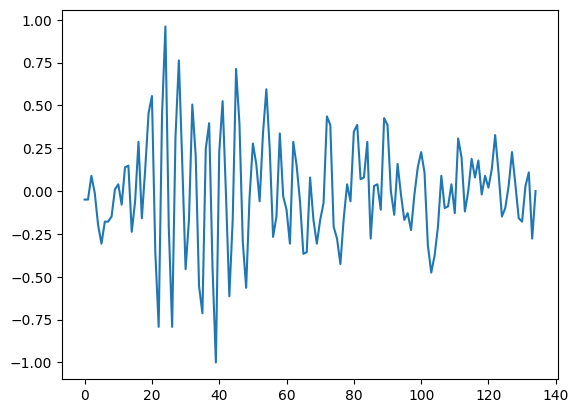

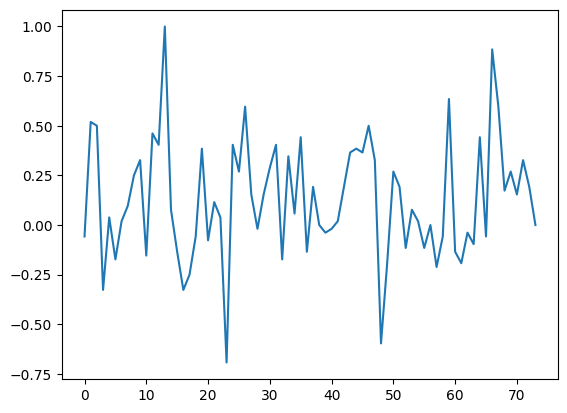

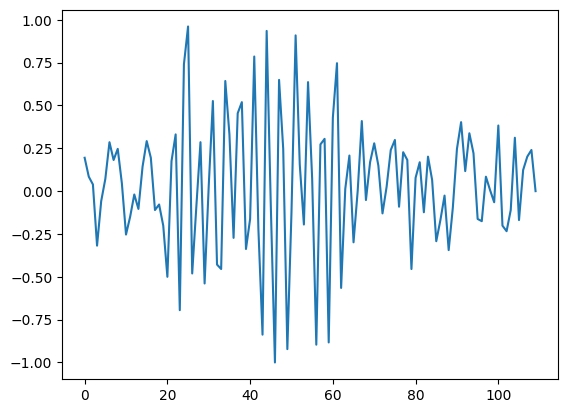

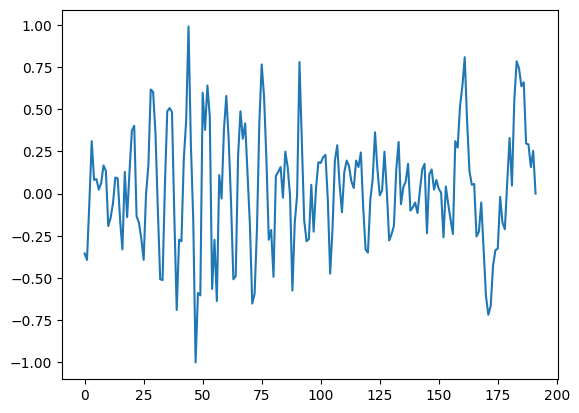

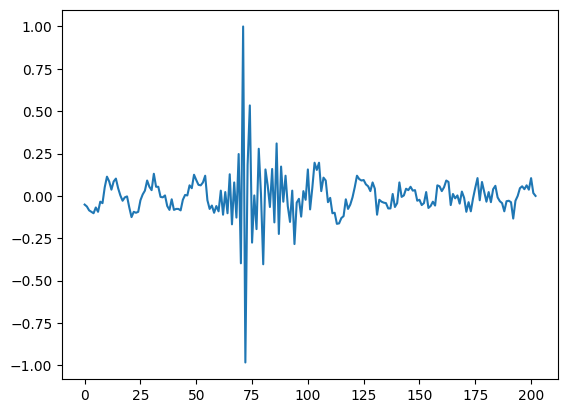

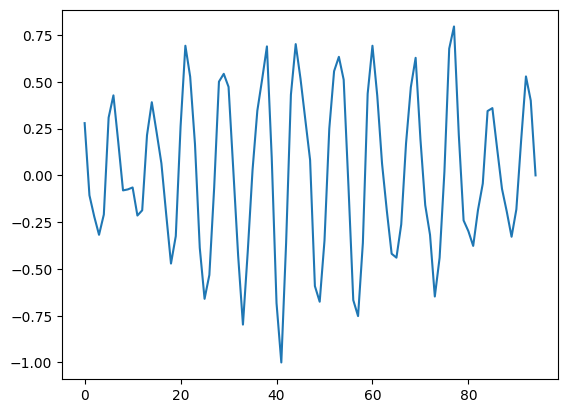

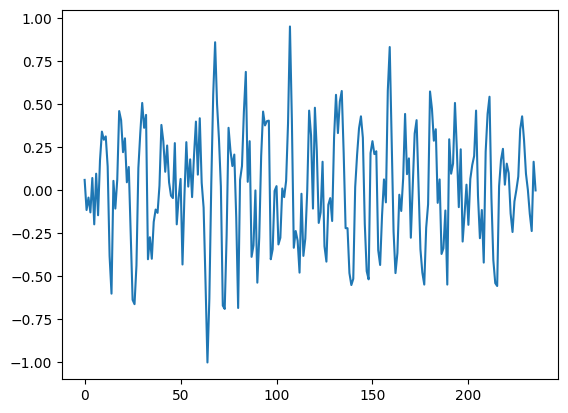

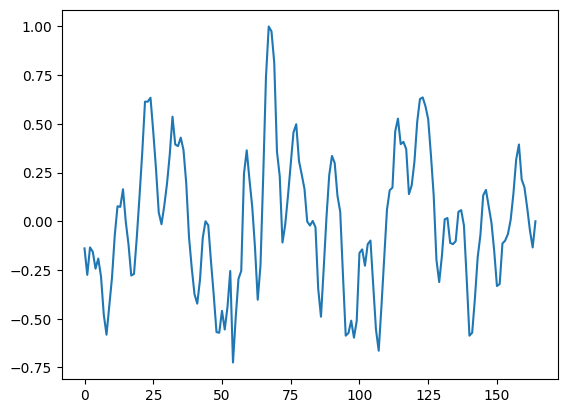

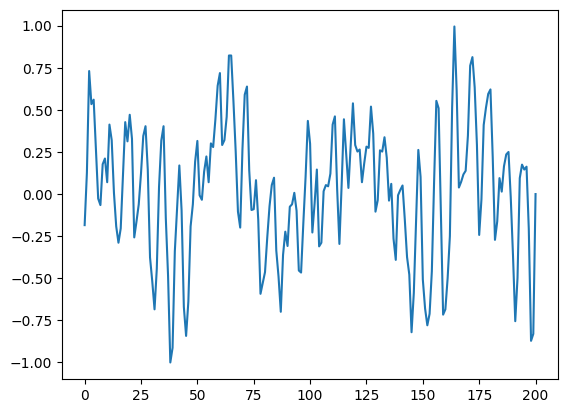

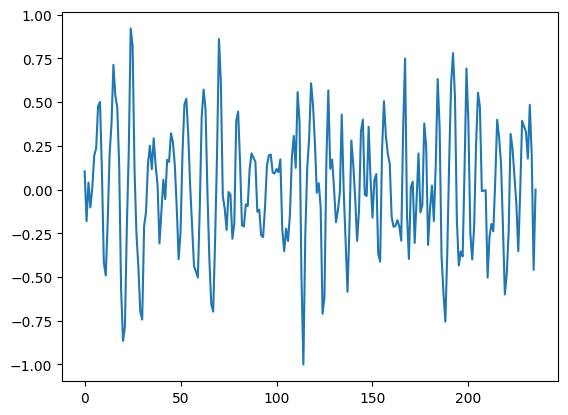

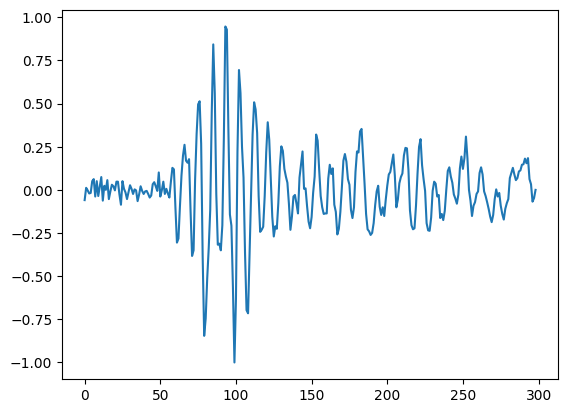

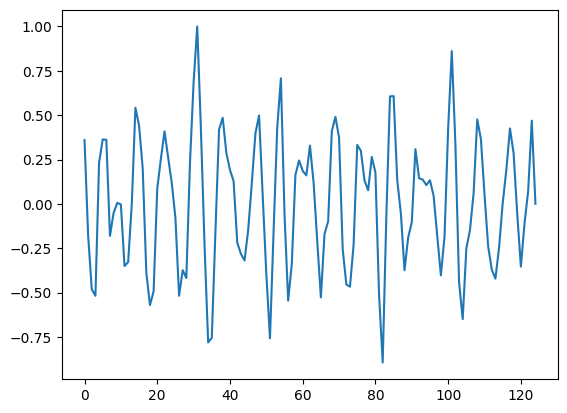

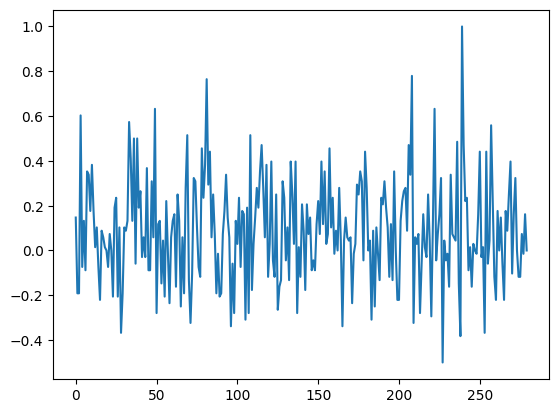

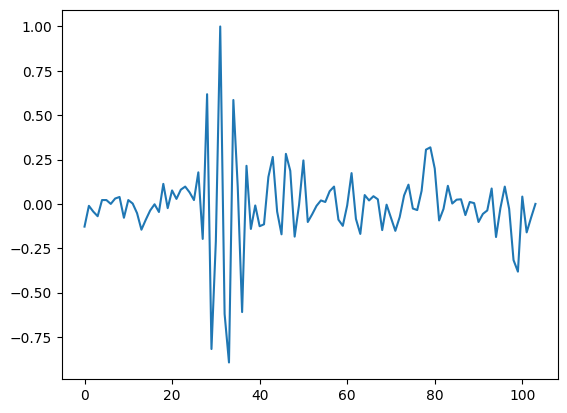

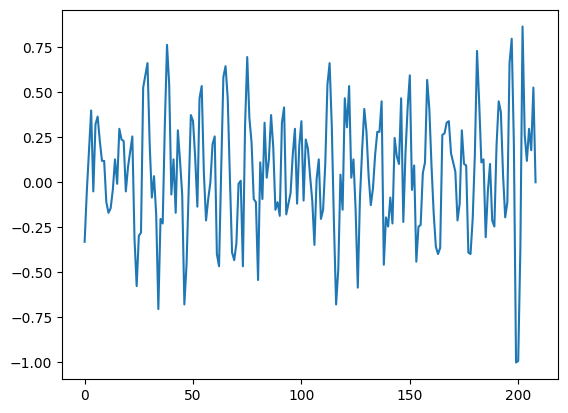

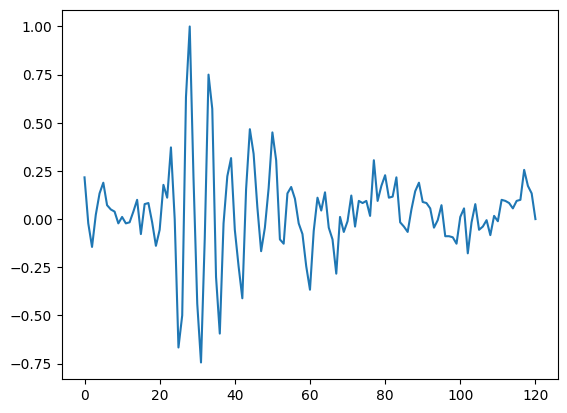

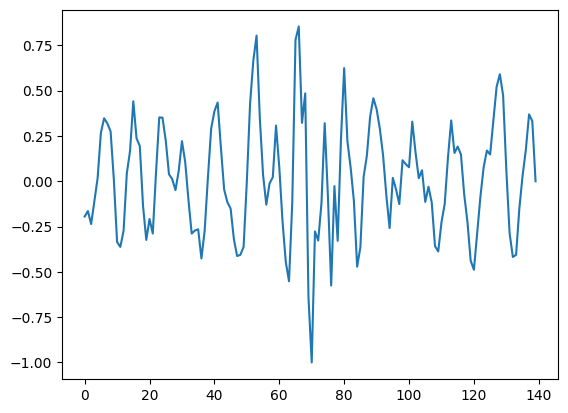

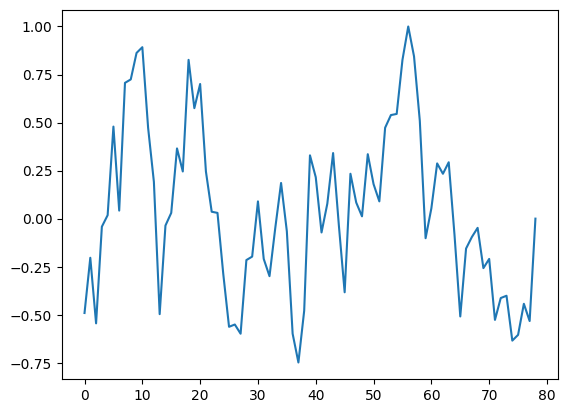

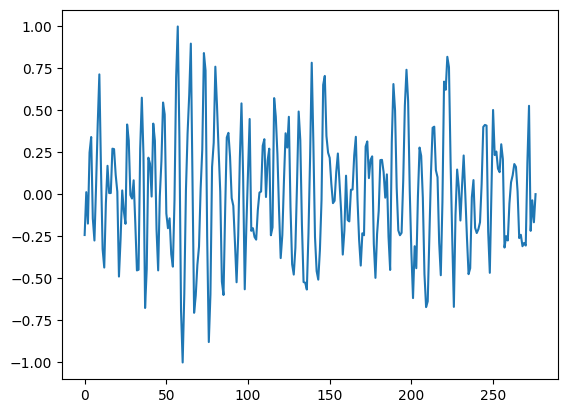

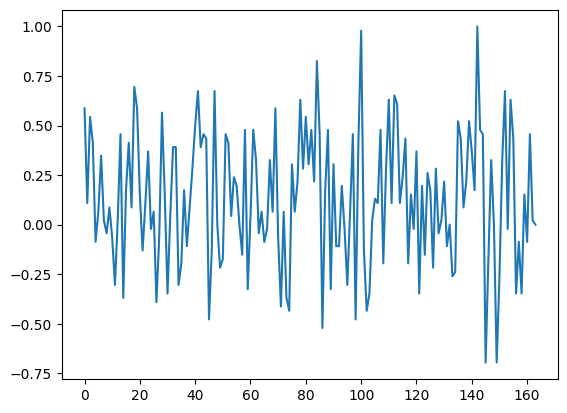

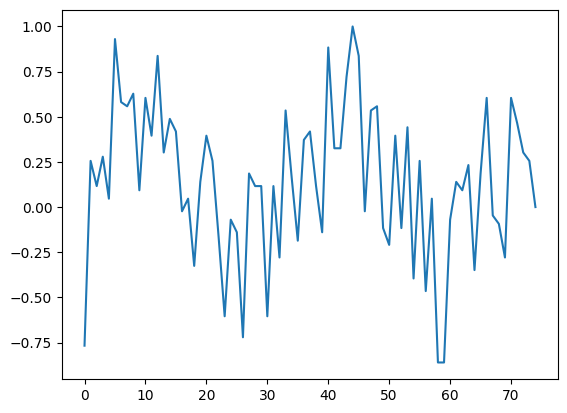

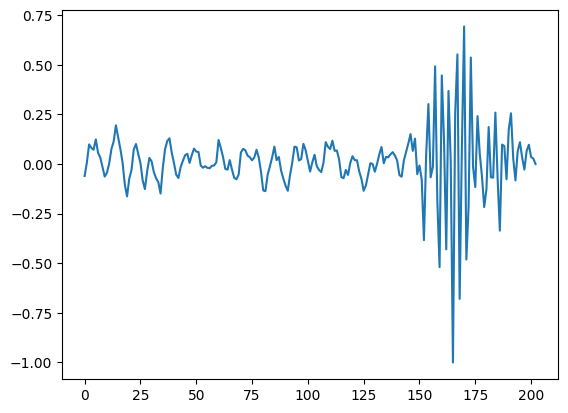

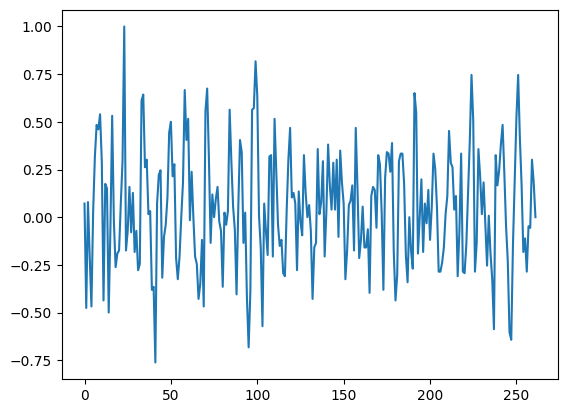

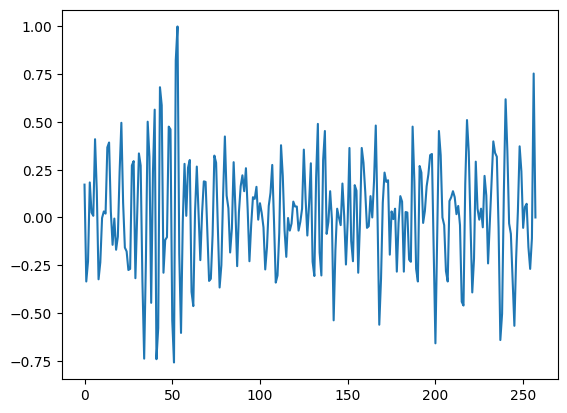

In [ ]:
for i in df_train[df_train['label'] == 0][:50].index:
    plt.plot(df_train.iloc[i].dropna().values)
    plt.show()

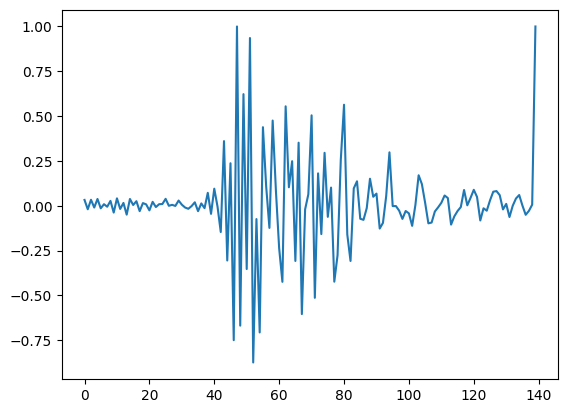

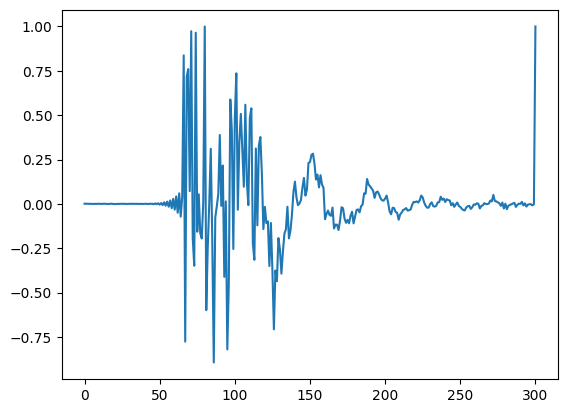

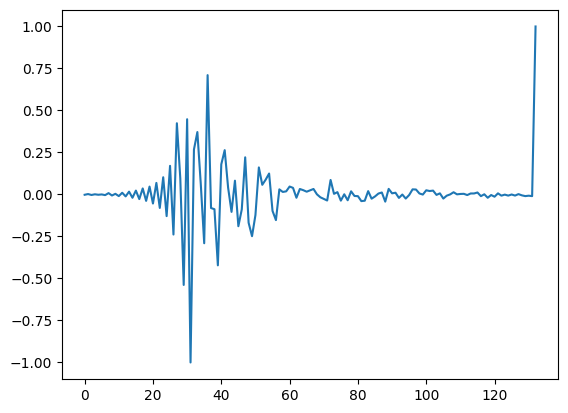

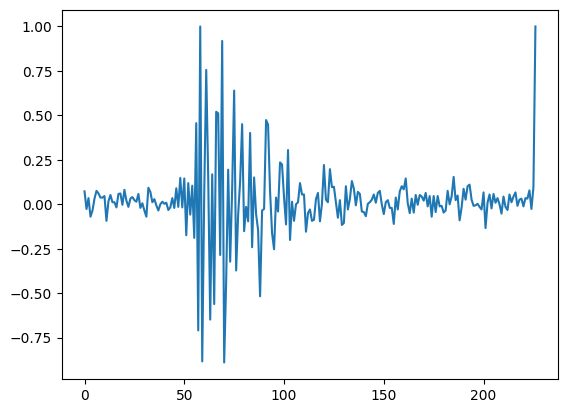

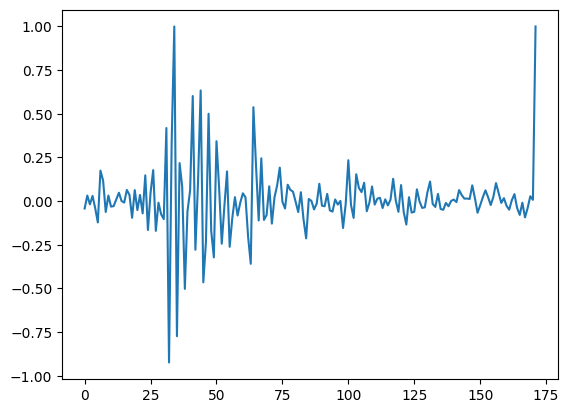

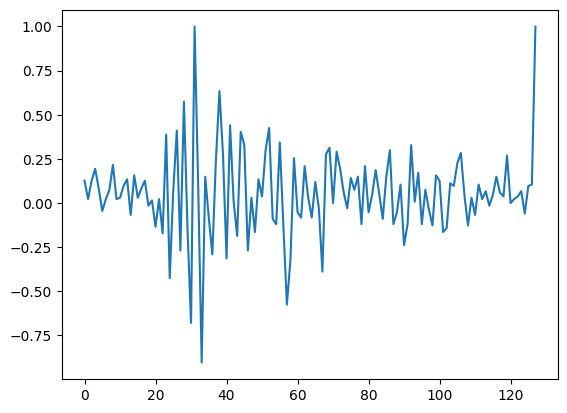

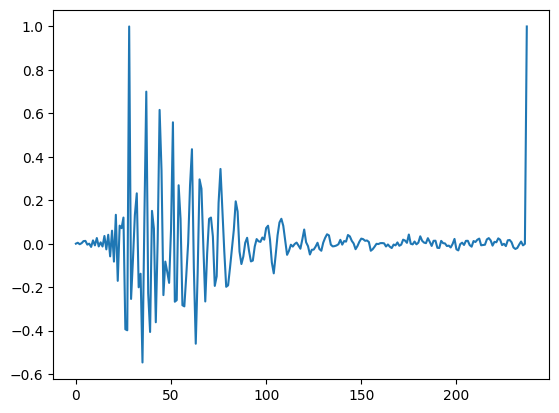

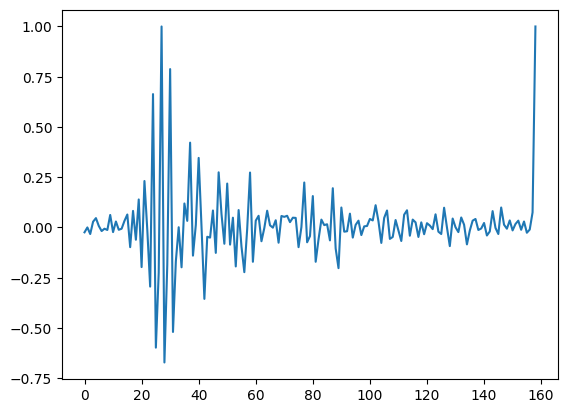

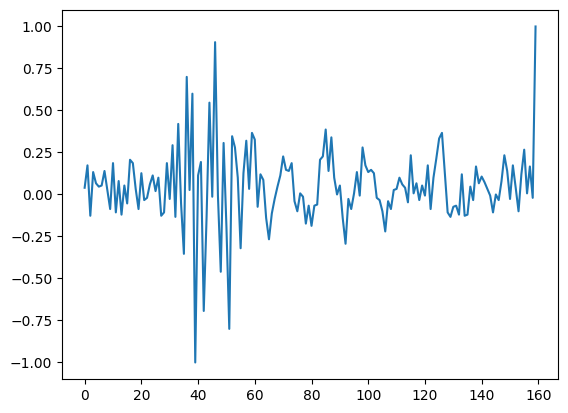

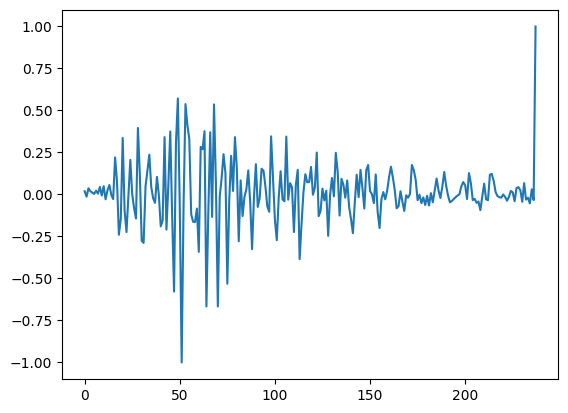

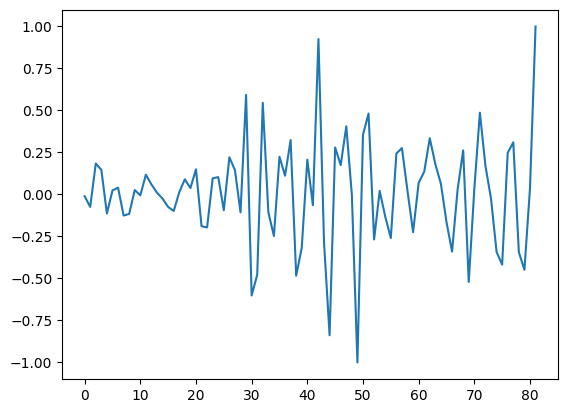

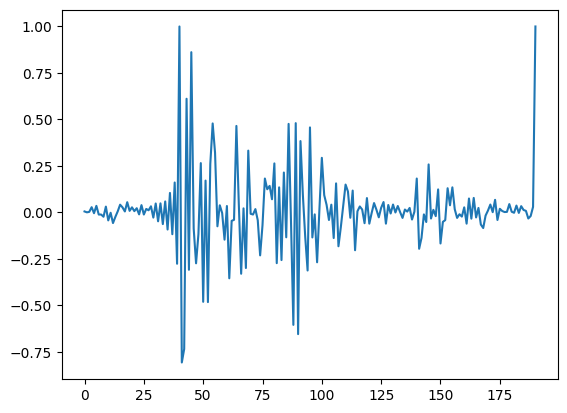

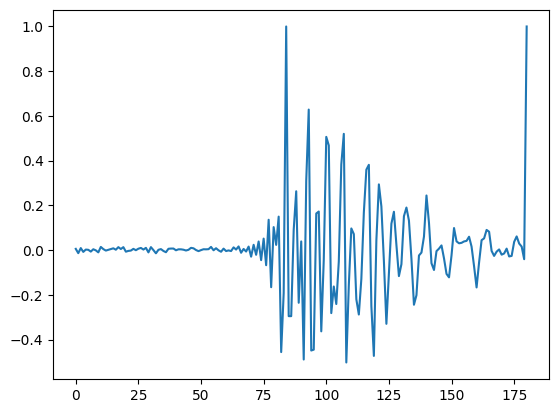

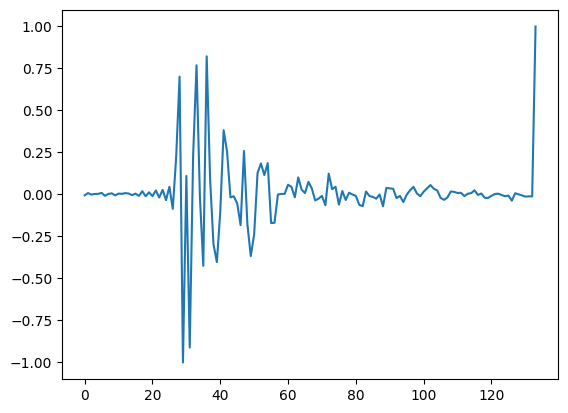

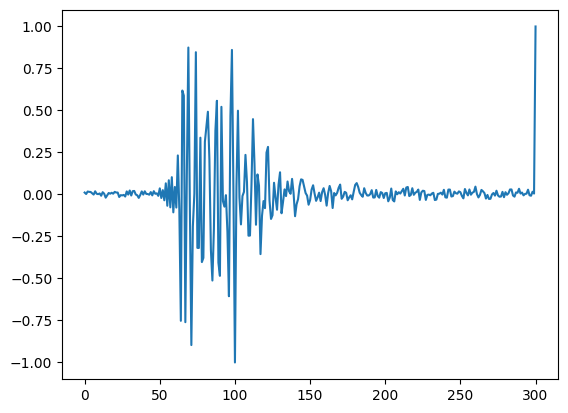

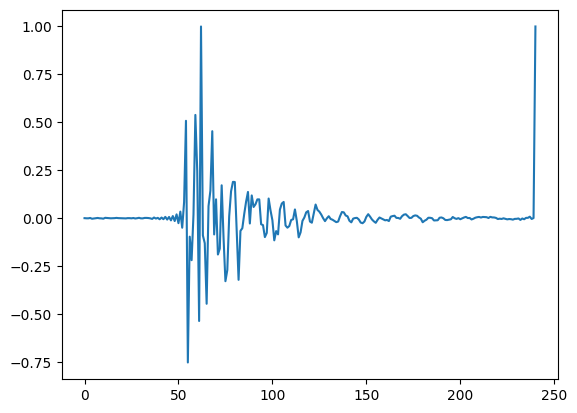

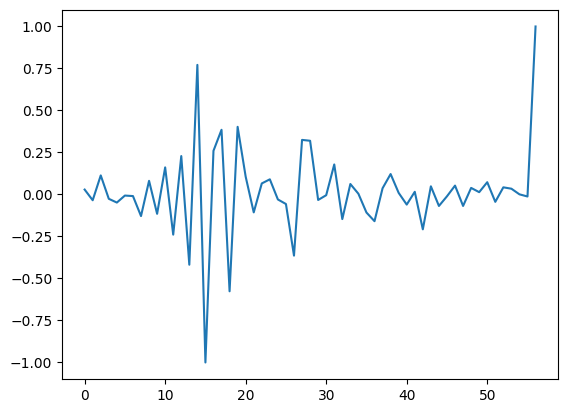

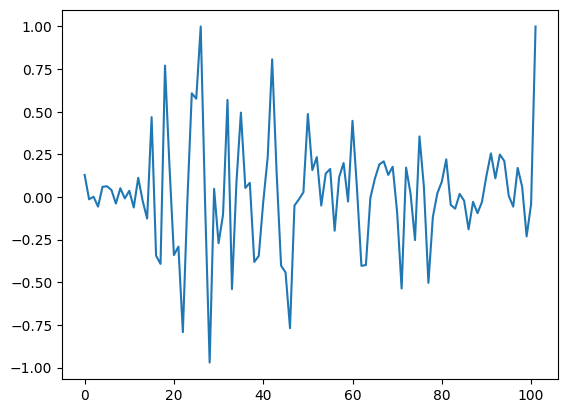

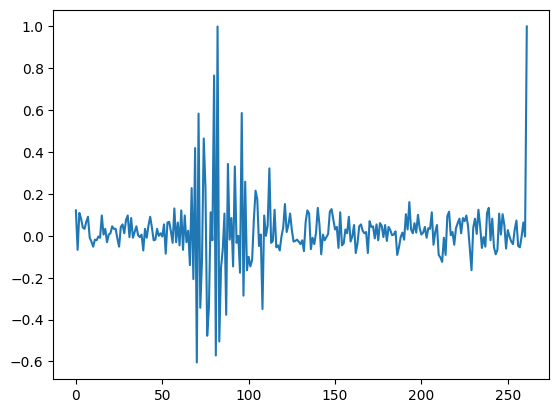

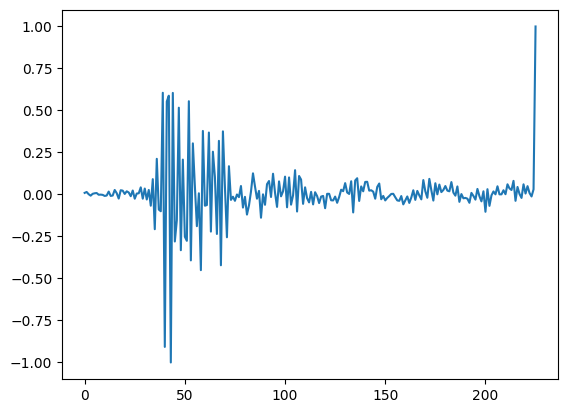

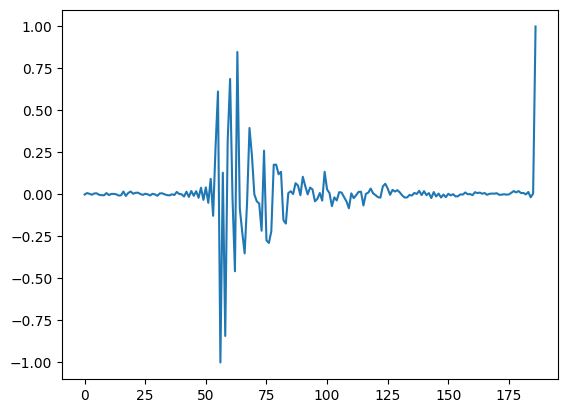

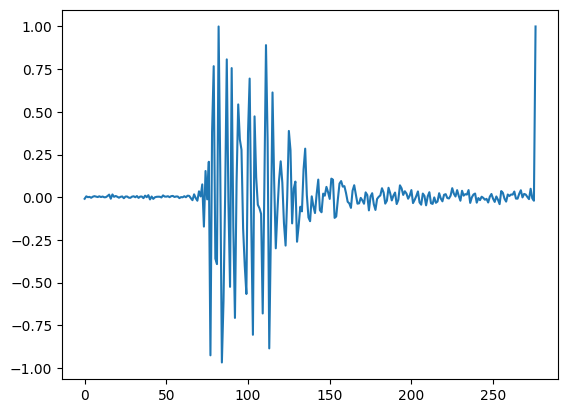

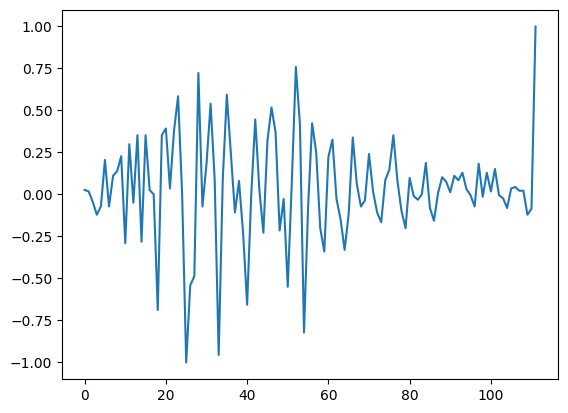

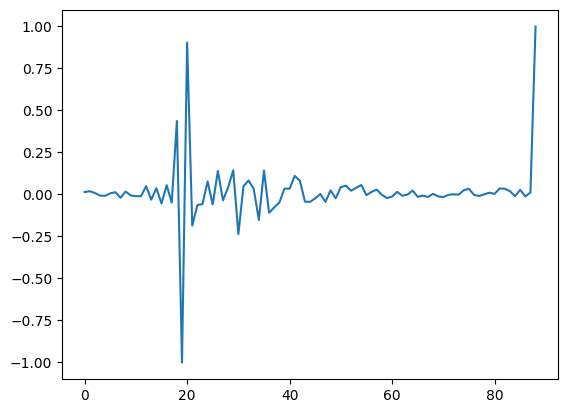

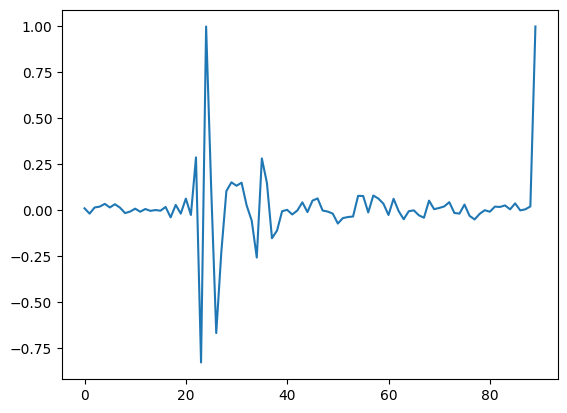

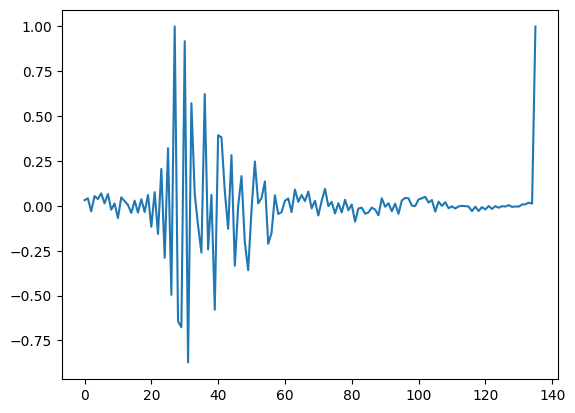

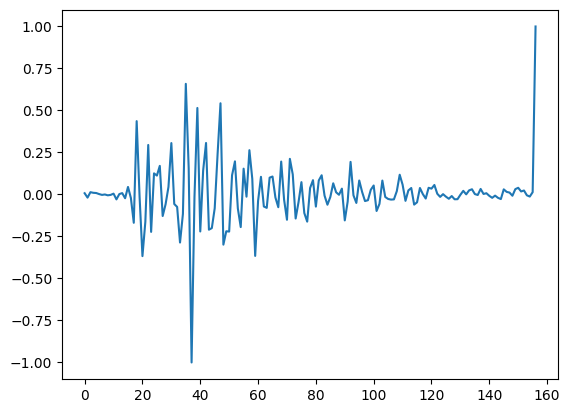

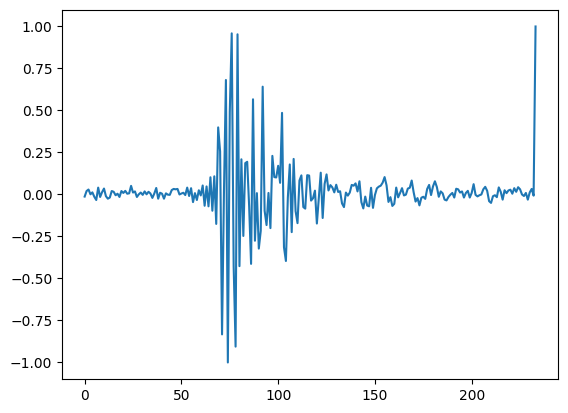

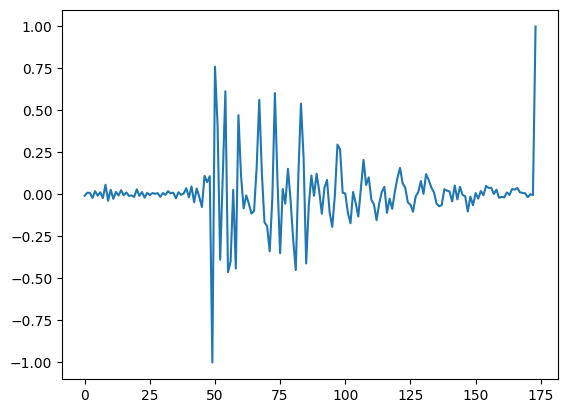

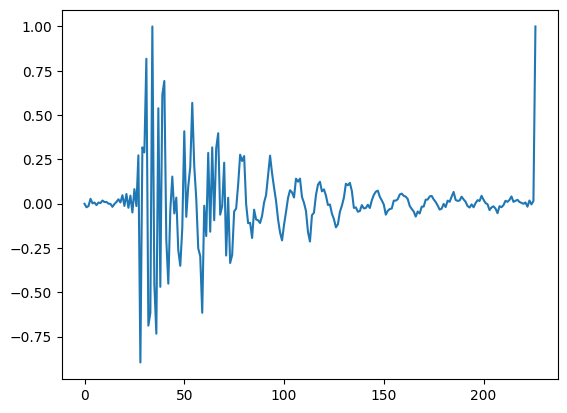

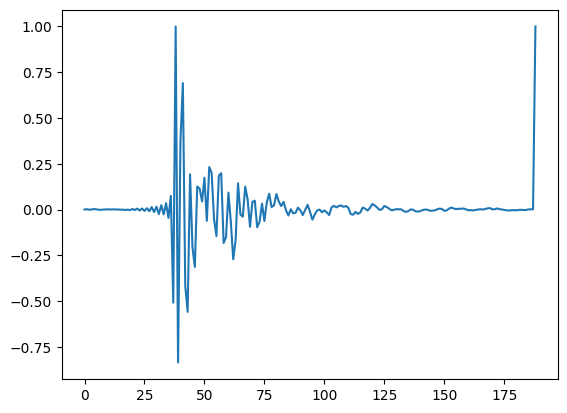

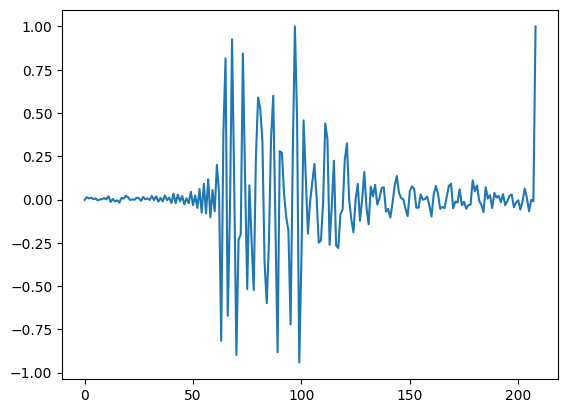

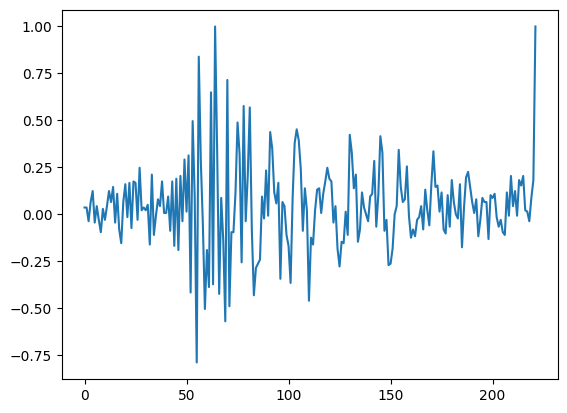

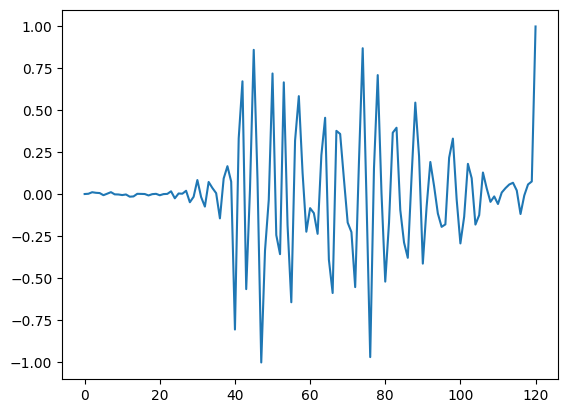

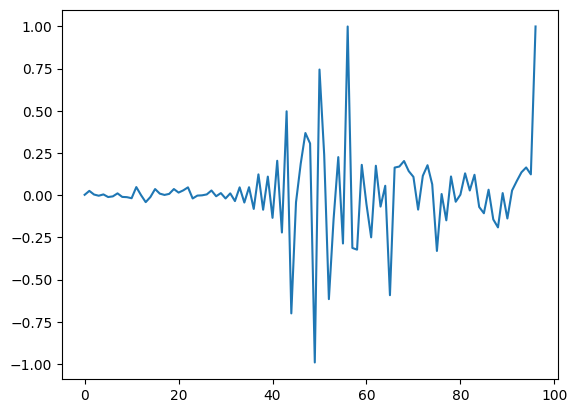

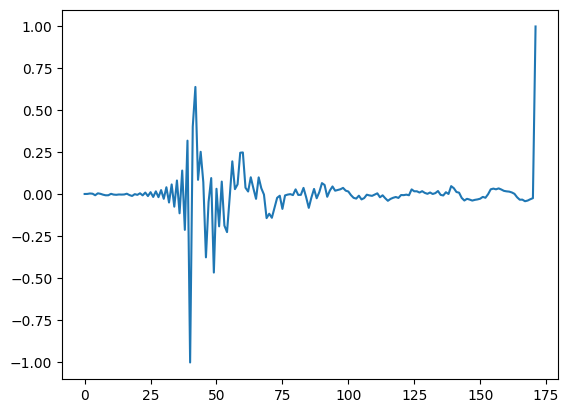

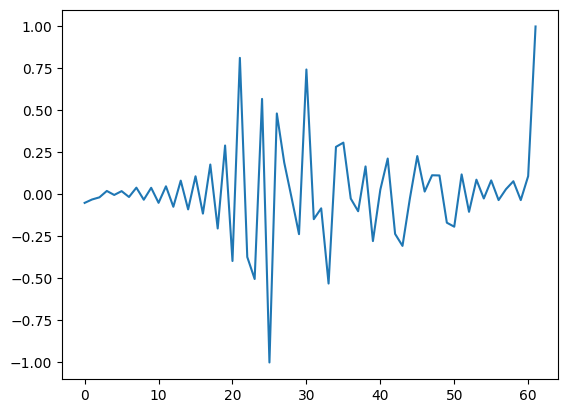

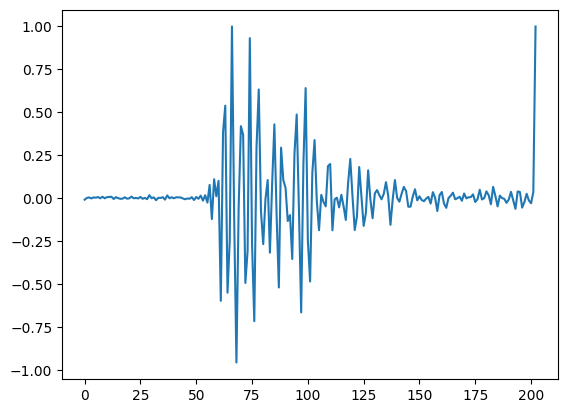

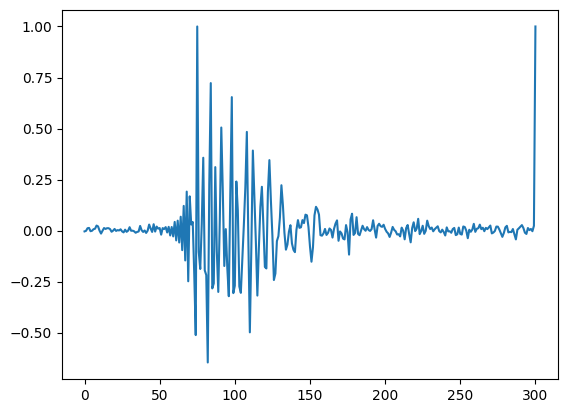

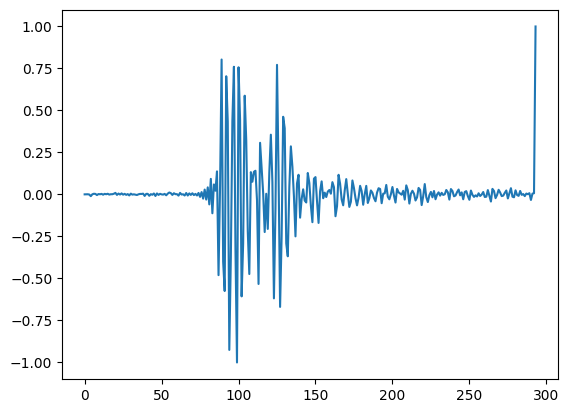

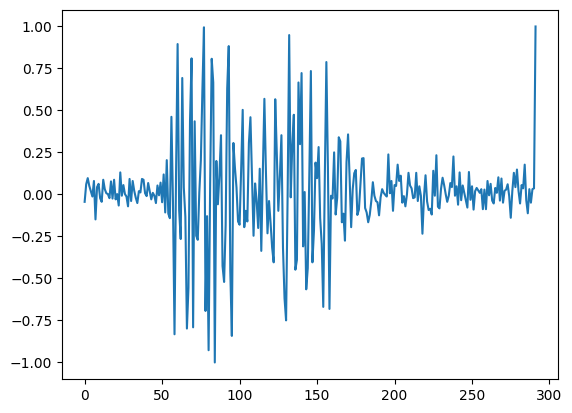

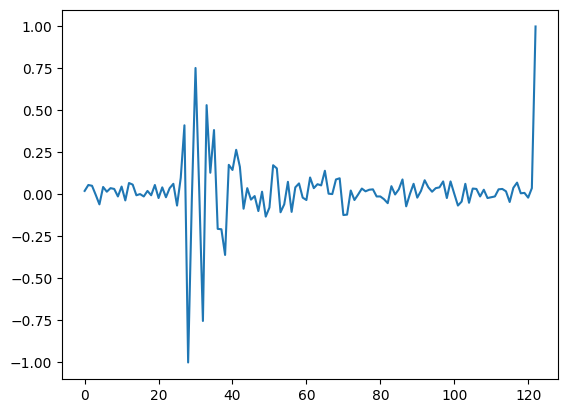

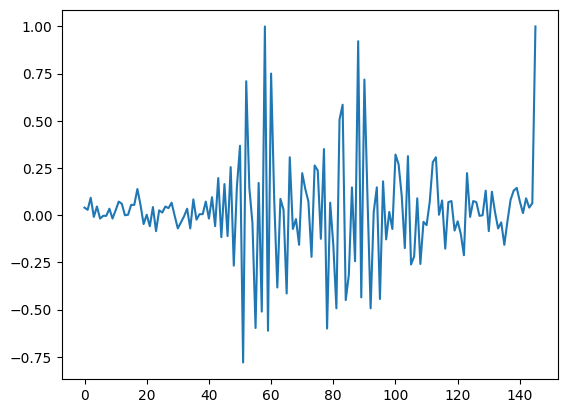

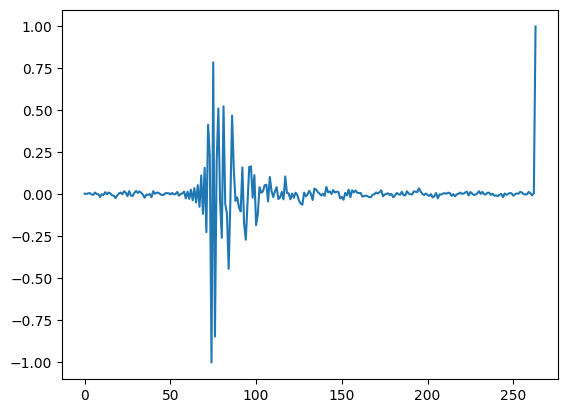

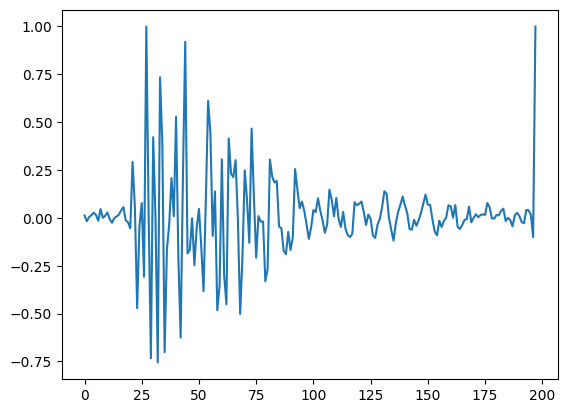

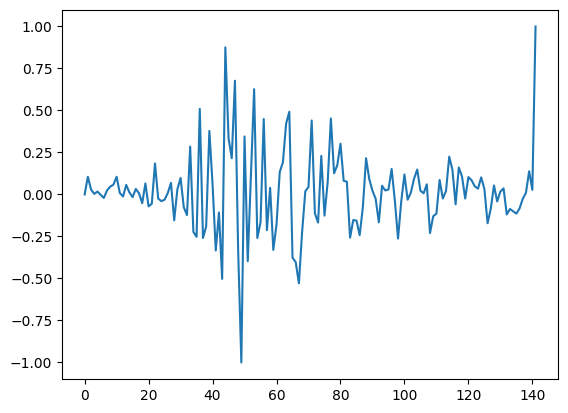

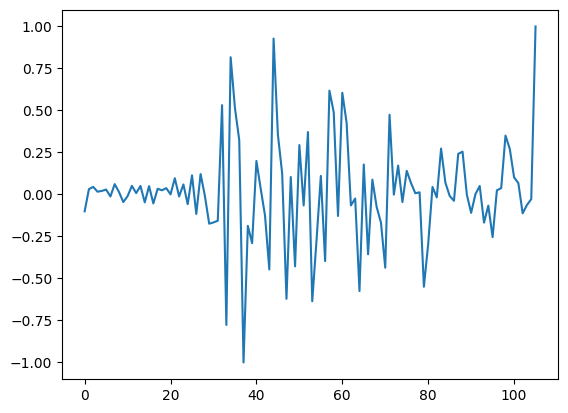

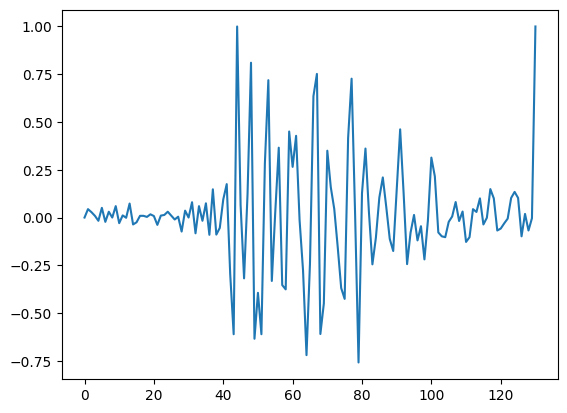

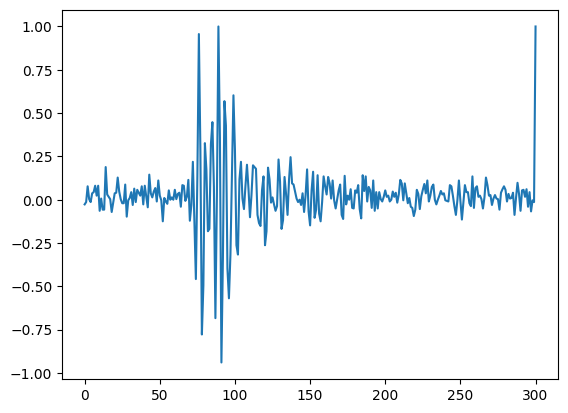

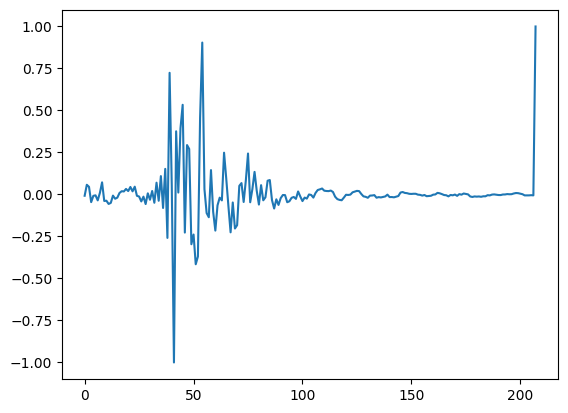

In [ ]:
for i in df_train[df_train['label'] == 1][:50].index:
    plt.plot(df_train.iloc[i].dropna().values)
    plt.show()

### распределение классов

In [ ]:
not_sand = 3130
sand = 662
all_sand = 3792

print(f'Данных 0 - {round(not_sand/all_sand * 100, 1)}%')
print(f'Данных 1 - {round(sand/all_sand * 100,1)}%')

Данных 0 - 82.5%
Данных 1 - 17.5%


<Axes: xlabel='Label'>

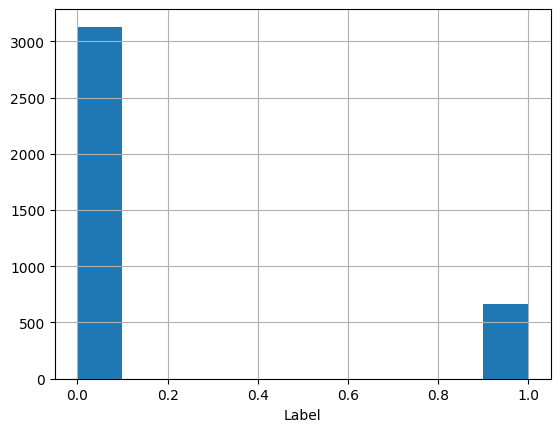

In [18]:
plt.xlabel('Label')
df_train['label'].hist()

#Feature engineering

In [19]:
df_train['mean'] = df_train.mean(axis=1)
# df_train['median'] = df_train.median(axis=1)

In [20]:
df_train['belowZero'] = df_train[(df_train.drop(['label'], axis=1) < 0)].sum(axis=1)
df_train['upperZero'] = df_train[(df_train.drop(['label'], axis=1) > 0)].sum(axis=1)

In [21]:
df_train = df_train.fillna(-999)

In [22]:
df_train.head()

data_1    data_2    data_3    data_4    data_5    data_6    data_7  \
0 -0.266033 -0.496437 -0.572447 -0.220903  0.266033  0.643705  0.365796   
1  0.125475 -0.007605 -0.030418  0.285171  0.574144  0.418251  0.304183   
2  0.130435  0.445652  0.358696  0.086957 -0.076087  0.173913  0.173913   
3  0.032628 -0.019400  0.033510 -0.009700  0.037919 -0.014109  0.008818   
4  0.006105  0.005723  0.004197 -0.001145 -0.009538 -0.009538 -0.000382   

     data_8    data_9   data_10  ...  data_295  data_296  data_297  data_298  \
0  0.375297  0.014252 -0.527316  ...    -999.0    -999.0    -999.0    -999.0   
1  0.277567  0.433460  0.231939  ...    -999.0    -999.0    -999.0    -999.0   
2  0.304348  0.141304  0.304348  ...    -999.0    -999.0    -999.0    -999.0   
3 -0.005291  0.027337 -0.037919  ...    -999.0    -999.0    -999.0    -999.0   
4 -0.006868 -0.006105 -0.012591  ...    -999.0    -999.0    -999.0    -999.0   

   data_299  data_300  label      mean  belowZero  upperZero  
0    -999.0    -999.0      0  0.013811 -25.904988  28.004310  
1    -999.0    -999.0      0  0.018010 -29.638783  33.348808  
2    -999.0    -999.0      0  0.068807 -10.608696  18.177503  
3    -999.0    -999.0      1  0.012856  -9.221340  10.034020  
4    -999.0    -999.0      0 -0.000397 -14.342251  14.232354  

[5 rows x 304 columns]

<Axes: >

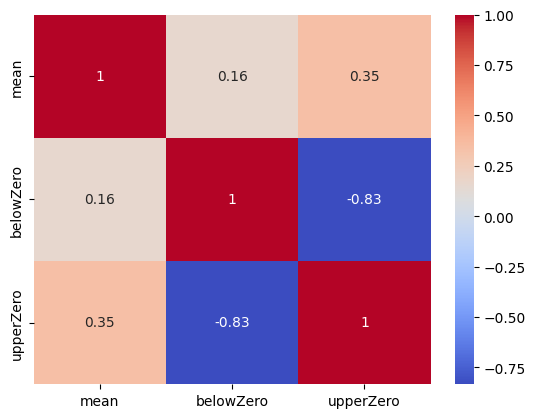

In [23]:
added_features = ['mean','belowZero', 'upperZero']


sns.heatmap(df_train[added_features].corr(),
            annot=True,
            cmap='coolwarm')

## Разделение на train_test

In [27]:
from sklearn.model_selection import train_test_split

X = df_train.drop(['label'], axis=1)
y = df_train['label']

trainX, testX, trainY, testY = train_test_split(X, y, random_state=42, test_size=0.25)

# Обучение Catboost

In [ ]:
model = CatBoostClassifier(
    custom_loss=[metrics.F1()],
    depth=3,
        iterations=3500,
        learning_rate=0.01,
        
        # Регуляризация и ускорение
        colsample_bylevel=0.098,
        subsample=0.95,
        l2_leaf_reg=9,
        min_data_in_leaf=243,
        max_bin=187,
        random_strength=1,
        
        # Параметры скорения
        task_type="CPU",    
        thread_count=-1,
        bootstrap_type="Bernoulli", 
        
        # Важное!
        random_seed=42,
        auto_class_weights="Balanced",
        early_stopping_rounds=100
)
model.fit(trainX, trainY,
          eval_set=(testX, testY),
          early_stopping_rounds=100,
          verbose=1000,
          )

0:	learn: 0.6836622	test: 0.6836827	best: 0.6836827 (0)	total: 2.54ms	remaining: 8.88s
1000:	learn: 0.0860920	test: 0.1065189	best: 0.1064988 (998)	total: 3.89s	remaining: 9.72s
2000:	learn: 0.0445477	test: 0.0907237	best: 0.0907126 (1996)	total: 5.98s	remaining: 4.48s
3000:	learn: 0.0280826	test: 0.0853728	best: 0.0853504 (2970)	total: 8.08s	remaining: 1.34s
3499:	learn: 0.0230168	test: 0.0834223	best: 0.0834197 (3498)	total: 9.1s	remaining: 0us

bestTest = 0.0834197238
bestIteration = 3498

Shrink model to first 3499 iterations.


## кросс-валидация catboost

In [31]:
from sklearn.model_selection import KFold  # k-фолдная валидация
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

0:	learn: 0.6875775	test: 0.6878375	best: 0.6878375 (0)	total: 10.9ms	remaining: 38.2s
1000:	learn: 0.0903366	test: 0.1178377	best: 0.1178377 (1000)	total: 4.08s	remaining: 10.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1052254318
bestIteration = 1850

Shrink model to first 1851 iterations.


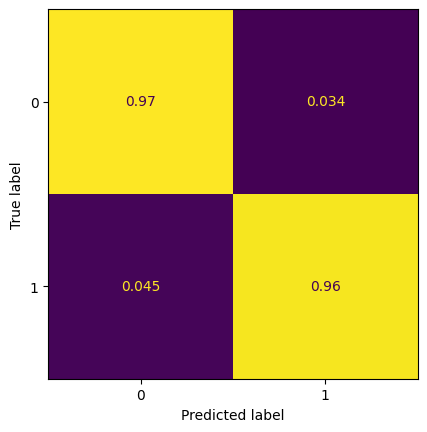

mean: 12.952275069227126
upperZero: 7.904649523569098
belowZero: 6.404519917028175
data_9: 4.706678854262237
data_5: 3.9640624836002534
0:	learn: 0.6870187	test: 0.6866516	best: 0.6866516 (0)	total: 3.94ms	remaining: 13.8s
1000:	learn: 0.0890258	test: 0.1148506	best: 0.1148506 (1000)	total: 3.22s	remaining: 8.05s
2000:	learn: 0.0524952	test: 0.1035242	best: 0.1033341 (1971)	total: 6.19s	remaining: 4.64s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1029196805
bestIteration = 2163

Shrink model to first 2164 iterations.


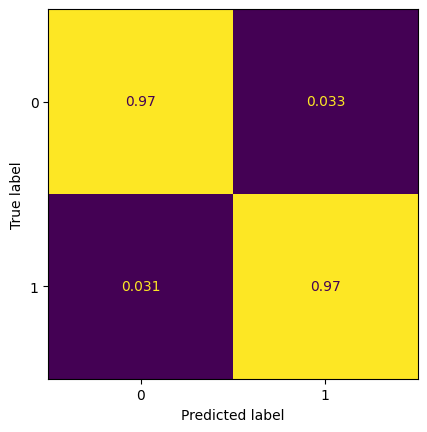

mean: 13.292838920677077
upperZero: 9.867512414461588
belowZero: 6.2003558153913145
data_9: 4.707613964587675
data_10: 4.184548371289329
0:	learn: 0.6858208	test: 0.6858575	best: 0.6858575 (0)	total: 3.33ms	remaining: 11.7s
1000:	learn: 0.0904115	test: 0.1109640	best: 0.1109640 (1000)	total: 3.68s	remaining: 9.19s
2000:	learn: 0.0548036	test: 0.0947106	best: 0.0946928 (1996)	total: 8.7s	remaining: 6.52s
3000:	learn: 0.0398041	test: 0.0918462	best: 0.0916378 (2967)	total: 11.6s	remaining: 1.93s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.09125596525
bestIteration = 3187

Shrink model to first 3188 iterations.


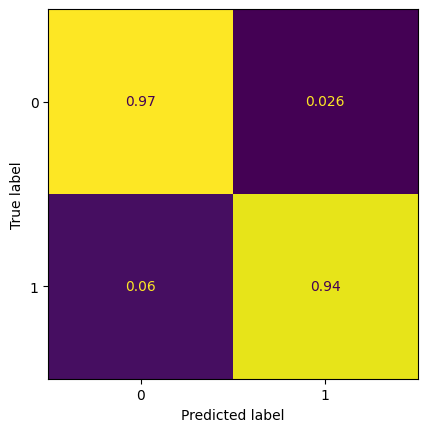

mean: 13.470306524987969
belowZero: 5.524199816074094
upperZero: 5.488414932353878
data_9: 4.75956093582777
data_10: 4.295353321183612
0:	learn: 0.6856633	test: 0.6861230	best: 0.6861230 (0)	total: 2.71ms	remaining: 9.49s
1000:	learn: 0.0865880	test: 0.1393412	best: 0.1393015 (999)	total: 2.99s	remaining: 7.47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.132773805
bestIteration = 1682

Shrink model to first 1683 iterations.


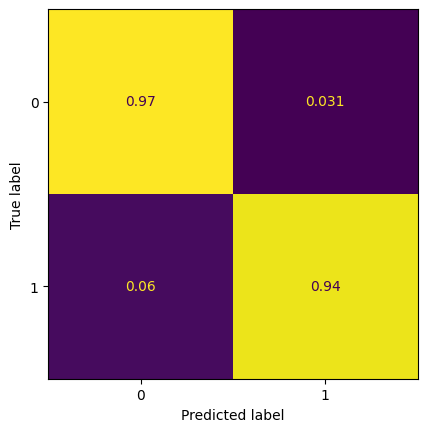

mean: 14.10993204295817
upperZero: 8.123325012731634
belowZero: 6.866447293799914
data_9: 4.135056429022761
data_5: 4.046192926326148
0:	learn: 0.6848170	test: 0.6852745	best: 0.6852745 (0)	total: 2.77ms	remaining: 9.69s
1000:	learn: 0.0886193	test: 0.1254043	best: 0.1253707 (999)	total: 2.93s	remaining: 7.31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1135257621
bestIteration = 1683

Shrink model to first 1684 iterations.


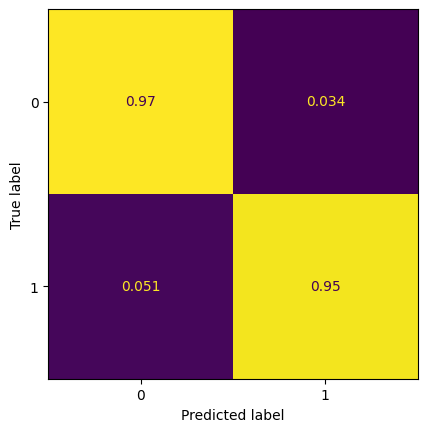

mean: 12.669910436411747
upperZero: 7.375295749282755
belowZero: 7.312464692499236
data_10: 5.434117442594296
data_9: 5.163589106027094
mean F1 score ---------> 0.9263


In [32]:
n_splits = 5  # Число фолдов. Оптимально 3, 5 или 10
clfs = [] # Тут будем сохранять модели
scores = [] # Тут будем хранить скоры валидационных фолдов

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_dataset = Pool(data=X_train, label=y_train)
    eval_dataset = Pool(data=X_test, label=y_test)

    clf = CatBoostClassifier(
        depth=3,
        iterations=3500,
        learning_rate=0.01,

        custom_metric=["F1"],
        
        # Регуляризация и ускорение
        colsample_bylevel=0.098,
        subsample=0.95,
        l2_leaf_reg=9,
        min_data_in_leaf=243,
        max_bin=187,
        random_strength=1,
        
        # Параметры скорения
        task_type="CPU",    
        thread_count=-1,
        bootstrap_type="Bernoulli", 
        
        # Важное!
        random_seed=42,
        auto_class_weights="Balanced",
        early_stopping_rounds=100)

    clfs.append(clf)

    clf.fit(
        train_dataset,
        eval_set=eval_dataset,
        verbose=1000,
        use_best_model=True,
        plot=False)

    scores.append(np.mean([v for k, v in clf.best_score_["validation"].items() if "F1" in k], dtype="float16"))

    cm = confusion_matrix(y_test,
                          clf.predict(X_test),
                          normalize='true',
                          labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(colorbar=False)
    plt.show()
    feature_importance = clf.get_feature_importance()

    feature_name = df_train.drop(['label'],axis=1).columns
    i = 0
    for score,name in sorted(zip(feature_importance, feature_name), reverse=True):
      if(i==5):
        break
      print(f"{name}: {score}")
      i+=1

assert len(clfs) == n_splits
print("mean F1 score --------->", np.mean(scores, dtype="float16") - np.std(scores, dtype="float16"))

In [ ]:
feature_importance = model.get_feature_importance()

feature_name = df_train.drop(['label'],axis=1).columns

for score,name in sorted(zip(feature_importance, feature_name), reverse=True):
  print(f"{name}: {score}")

mean: 12.108451931054587
upperZero: 8.542063253447363
belowZero: 5.499482621787069
data_9: 5.112445197958235
data_10: 3.9786900269272945
data_5: 3.2103606559271167
data_4: 3.0801570031765033
data_7: 2.9227540526261864
data_6: 2.8804877026451594
data_1: 2.8306903918989157
data_2: 2.809701384670115
data_3: 2.7936061167603565
data_13: 2.5044399453802733
data_8: 2.1914825108260994
data_11: 2.1796594119107056
data_14: 2.0143512079122177
data_12: 1.9421648199832797
data_16: 1.8509232312408472
data_18: 0.9618057134504778
data_15: 0.9358688366388891
data_19: 0.9190153324091097
data_20: 0.7771951785127619
data_17: 0.6331489321212996
data_52: 0.5461944020488217
data_32: 0.44329273290032534
data_40: 0.4244637885378032
data_179: 0.4174272439295166
data_134: 0.4087651365173234
data_153: 0.3862394364856352
data_146: 0.38426286548863753
data_124: 0.3804726696606738
data_55: 0.3770961748832106
data_70: 0.37433832630518804
data_137: 0.36163826100353547
data_29: 0.3503195741158425
data_51: 0.34120892597

# Попробовал использовать NN для обучения

## Dataset for NN

In [33]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()
X_train = scaler.fit_transform(trainX)
X_test = scaler.transform(testX)

In [34]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(trainY.to_numpy()))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test),
                     torch.FloatTensor(testY.to_numpy()))

In [35]:
train_loader = DataLoader(dataset=train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=8)

In [36]:
from sklearn.metrics import f1_score

def bin_f1(y_pred, y_batch):
  # ypred = torch.round(torch.sigmoid(y_pred)).cpu().detach().numpy()

  return f1_score(y_pred.cpu().detach().numpy(), y_batch.cpu().detach().numpy())

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## обучение NN Lightning

In [38]:
!pip install lightning -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.5/553.5 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import lightning.pytorch as pl

class SandClassifier(pl.LightningModule):
  
  def __init__(self):
    super().__init__()
    # Задается архитектура нейросети
    self.layers = nn.Sequential(
      nn.Linear(303, 150),
      nn.BatchNorm1d(150),
      nn.Dropout(p=0.1),
      nn.Softmax(dim=-1),
      nn.Linear(150, 2)
    )
    # Объявляется функция потерь
    self.loss_func = nn.CrossEntropyLoss()

    
  def forward(self, x):
    return self.layers(x)
  
  # Настраиваются параметры обучения
  def training_step(self, batch, batch_idx):
    current_epoch = 0
    x, y = batch
    x, y = x.to(device), y.to(device)
    # x = x.view(x.size(0), -1)
    y = y.to(torch.int64)
    pred = self.layers(x)
    loss = self.loss_func(pred, y)
    self.log('train_loss', loss)
    current_epoch += 1
    return loss
  
  def validation_step(self, batch, batch_idx):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y = y.to(torch.int64)
    # x = x.view(x.size(0), -1)
    pred = self.layers(x)
    loss = self.loss_func(pred, y)
    pred = torch.argmax(pred, dim=1)
    # accuracy = torch.sum(y == pred).item() / (len(y) * 1.0)

    f1 = bin_f1(pred, y)
    self.log('test_loss', loss, prog_bar=True)
    self.log('test_f1', torch.tensor(f1), prog_bar=True)
    output = dict({
        'test_loss': loss,
        'test_f1': torch.tensor(f1),
    })
    return output
  
  # Настраиваются параметры тестирования
  def test_step(self, batch, batch_idx):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y = y.to(torch.int64)
    # x = x.view(x.size(0), -1)
    pred = self.layers(x)
    loss = self.loss_func(pred, y)
    pred = torch.argmax(pred, dim=1)
    # accuracy = torch.sum(y == pred).item() / (len(y) * 1.0)

    f1 = bin_f1(pred, y)
    self.log('test_loss', loss, prog_bar=True)
    self.log('test_f1', torch.tensor(f1), prog_bar=True)
    output = dict({
        'test_loss': loss,
        'test_f1': torch.tensor(f1),
    })
    return output

  # Конфигурируется оптимизатор
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
    return optimizer

In [ ]:
import warnings
warnings.filterwarnings('ignore')

EPOCHS = 200

model = SandClassifier()
trainer = pl.Trainer(max_epochs=EPOCHS)

trainer.fit(model, train_loader, test_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type             | Params
-----------------------------------------------
0 | layers    | Sequential       | 46.2 K
1 | loss_func | CrossEntropyLoss | 0     
-----------------------------------------------
46.2 K    Trainable params
0         Non-trainable params
46.2 K    Total params
0.185     Total estimated model params size (MB)
INFO:light

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


# Тестовые данные

In [ ]:
df_test = pd.read_csv('test.csv')
df_test.head()

data_1    data_2    data_3    data_4    data_5    data_6    data_7  \
0  0.049618  0.054707 -0.027990 -0.001272 -0.011450 -0.002545  0.030534   
1  0.004296  0.016323  0.006014  0.006014  0.006873  0.025773  0.045533   
2  0.010651  0.001183  0.016568 -0.005917  0.013018  0.007101 -0.033136   
3  0.003610  0.041516 -0.009025  0.043321 -0.001805  0.037906 -0.032491   
4 -0.047438  0.024566  0.016942  0.045320  0.086828  0.047014 -0.039390   

     data_8    data_9   data_10  ...  data_291  data_292  data_293  data_294  \
0 -0.005089  0.010178 -0.036896  ...       NaN       NaN       NaN       NaN   
1  0.032646 -0.011168  0.012887  ...       NaN       NaN       NaN       NaN   
2  0.009467  0.029586  0.003550  ...       NaN       NaN       NaN       NaN   
3  0.041516  0.025271  0.007220  ...       NaN       NaN       NaN       NaN   
4 -0.077510 -0.035578 -0.033460  ...       NaN       NaN       NaN       NaN   

   data_295  data_296  data_297  data_298  data_299  data_300  
0       NaN       NaN       NaN       NaN       NaN       NaN  
1       NaN       NaN       NaN       NaN       NaN       NaN  
2       NaN       NaN       NaN       NaN       NaN       NaN  
3       NaN       NaN       NaN       NaN       NaN       NaN  
4       NaN       NaN       NaN       NaN       NaN       NaN  

[5 rows x 300 columns]

In [ ]:
df_test['mean'] = df_test.mean(axis=1)
df_test['belowZero'] = df_test[(df_test < 0)].sum(axis=1)
df_test['upperZero'] = df_test[(df_test > 0)].sum(axis=1)

In [ ]:
df_test = df_test.fillna(-999)

In [ ]:
test_pred = model.predict(df_test)

In [ ]:
pd.DataFrame(test_pred, columns=['label']).to_csv('submit.csv', index=False)